# Produce Feature Vectors

### Load Imports and Files

In [1]:
%run imports.py

/home/ayush/miniconda3/envs/scan/lib/python3.8/site-packages/pymatgen/ext/matproj.py:454: DeprecationWarning:

__init__ is deprecated
MaterialsProjectCompatibility will be updated with new correction classes as well as new values of corrections and uncertainties in 2020



Imports successfully loaded


In [2]:
masks = loadfn('data/masks.json')
elfcars = loadfn('data/elfcars.json')

In [3]:
ids = [i for i in masks.keys()]
print(ids)

['6405', '5600', '8356', '3890', '7373', '11133', '5804', '10090', '3914', '3957', '3947', '3955', '4648', '4827', '6017', '3901', '5450', '6454', '11002', '9634', '3926', '3992', '4311', '5692', '4019', '6110', '6240', '7703', '8519', '7365', '8363', '4617', '4079', '8414', '8172', '10118', '4832', '3976', '6262', '10408', '6359', '5058', '4155', '4406', '3950', '2072', '2597', '4700', '4226', '4682', '5193', '10746', '9102', '8247', '4202', '11163', '4153', '4251', '7003', '9583', '6155', '8509', '7722', '7034', '10596', '7731', '3996', '11143', '10598', '7879', '10545', '10580', '8466', '3915', '6450', '4611', '10270', '11176', '5557', '5688', '6417', '6360', '7356', '8186', '8884', '4283', '4826', '4252', '2345', '3942', '3930', '3923', '3929', '8986', '9927', '5874', '6412', '7468', '2820', '5540', '6295', '6341', '11185', '5312', '7408', '2840', '8234', '5236', '5614', '7476', '7494', '8436', '4896', '10792', '11087', '4742', '9288', '6862', '4757', '2085', '6101', '6094', '7239'

### Prepare Element Statistics

In [4]:
element_formulas_ids = loadfn('data/element_formulas_ids.json')

In [5]:
element_elfcars = {}

for f, ID in element_formulas_ids.items():
    element_elfcars[f] = elfcars[str(ID)]

In [6]:
for f in element_elfcars.keys():
    e = element_elfcars[f]

In [7]:
element_statistics = {}

for f in element_elfcars.keys():
    spatial_data = element_elfcars[f].get_alpha().data['total'].flatten()
    element_statistics[f] = [np.mean(spatial_data), np.std(spatial_data), np.max(spatial_data)]

In [8]:
pprint(element_statistics)

{'Ac': [2.3952880904166385, 0.9221624536523357, 4.186004617717708],
 'Ag': [4.373444566115248, 9.3601895754998, 179.08046335007322],
 'Al': [1.7857315750123286, 1.303596186758892, 21.19068202065356],
 'Ar': [10.08894643061993, 11.014270879716667, 65.85032868291142],
 'As': [2.927476565281586, 2.4780503446526985, 10.965066987160945],
 'Au': [3.4875908165023946, 3.5191039435277944, 45.239207511055575],
 'B': [2.4804683886419365, 2.2235692605077135, 22.52643126985591],
 'Ba': [2.9255046533821023, 1.5481167338698114, 6.574370690467469],
 'Be': [2.0735385961683694, 1.3075652461540779, 6.386318005187307],
 'Bi': [2.5172121868344575, 1.948098995393369, 11.225414565916763],
 'Br': [4.945517100257024, 4.845327657368386, 19.997851987445422],
 'C': [4.143758773426854, 4.089905490463662, 19.370301237493063],
 'Ca': [2.9976317340345755, 2.0591215822889666, 8.90733654534101],
 'Cd': [3.6707442427955344, 6.161494326827701, 128.98490061679868],
 'Ce': [2.3377263456297652, 0.9978052527804198, 8.2886055

### Mask Application & Feature Vector Methods

In [9]:
def create_mask(mask, index):
    shape = mask.shape
    flat = mask.flatten()
    for i in range(len(flat)):
        flat[i] = 1 if int(flat[i]) == index else 0
    mask = flat.reshape(shape)
    return mask

# def apply_mask(elfcar, mask):
#     ex, ey, ez = elfcar.shape
#     mx, my, mz = mask.shape
#     masked = []
#     for i1 in range(len(elfcar)):
#         xfac = int(mx / ex)
#         for i2 in range(len(elfcar[i1])):
#             yfac = int(my / ey)
#             for i3 in range(len(elfcar[i1][i2])):
#                 zfac = int(mz / ez)
#                 masked.append(elfcar[i1][i2][i3] * mask[i1 * xfac][i2 * yfac][i3 * zfac])
#     return np.array(masked)

def apply_mask(elfcar, mask):
    ex, ey, ez = elfcar.shape
    mx, my, mz = mask.shape
    xfac, yfac, zfac = int(mx / ex), int(my / ey), int(mz / ez)
    mask_trimmed = mask[::xfac, ::yfac, ::zfac]
    return elfcar * mask_trimmed

def strip_zeros(arr):
    arr = arr.flatten()
    return np.array([a for a in arr if a != 0])

In [10]:
def zipper(l1, l2):
    i1, i2 = iter(l1), iter(l2)
    for _ in range(max(len(l1), len(l2))):
        try:
            yield next(i1)
        except StopIteration:
            pass
        try:
            yield next(i2)
        except StopIteration:
            pass
        
zip_lists = lambda l1, l2: [x for x in zipper(l1, l2)]   
flatten_list = lambda l: [y for x in l for y in x]

#### Feature Vector Specifications:
- 12 Bader wells are used to construct each vector
- Zipper fashion: cation, anion, cation, anion, ...
- Well statistics are offset by element statistics
    - v_i = Bader_stat - elem_stat
- For each well: \[mean - e_mean, std - e_std, max - e_max\]
- Total length of 36 = 12 * 3
- If less than 12 Bader wells, fill with existing data until len(v) = 36

In [11]:
potential_problems = []

def retrieve_objects_methods(i):
    elfcar, mask = elfcars[i].get_alpha(), masks[i]
    elfcar_data, mask_data = elfcar.data['total'], mask.data['total']
    struct = masks[i].structure
    composition = struct.composition
    assert composition == elfcar.structure.composition, 'ELFCAR & mask compositions aren\'t equal'
    cation, anion = [str(e) for e in composition.elements]
    
    def vectorize_well(index):
        f = str(struct.sites[index - 1].specie)
        assert(mask.value_at(*struct.sites[index - 1].frac_coords) != 0.0) #Ensure atom index matches Bader well
        clean_mask = strip_zeros(apply_mask(elfcar_data, create_mask(mask_data, index)))
        if not clean_mask.any():
            clean_mask = np.array([0.0, 0.0, 0.0])
            potential_problems.append(mask.structure.composition.reduced_formula)
        mean, std, Max = np.mean(clean_mask), np.std(clean_mask), np.max(clean_mask)
        elem_mean, elem_std, elem_max = element_statistics[f]
        vi = [mean - elem_mean, std - elem_std, Max - elem_max]
        if f == cation:
            return vi, True
        elif f == anion:
            return vi, False
        else:
            raise AssertionError('Current atom neither a cation nor an anion')
            
    return composition, vectorize_well

def trim_vector(vector, length, ndescriptors,fillzero):
    if len(vector) > length:
        vector = vector[:length]
    elif len(vector) < length:
        if fillzero:
            while len(vector) < length:
                vector.append(0.0)
        else:
            idx = 0
            while len(vector) < length:
                vector += vector[idx:idx+ndescriptors]
                idx += ndescriptors
    return vector

def feature_vector(i, num_wells=12, fillzero=False):
    composition, vectorize_well = retrieve_objects_methods(i)
    cation_vectors, anion_vectors = [], []
    for index in range(1, int(composition.num_atoms) + 1):
        vi, flag = vectorize_well(index)
        if flag:
            cation_vectors.append(vi)
        else:
            anion_vectors.append(vi)
            
    ndescriptors = len(cation_vectors[0])
    length = num_wells * ndescriptors
    vector = trim_vector(flatten_list(zip_lists(cation_vectors, anion_vectors)), length, ndescriptors, fillzero)
    return np.array(vector)
    return vector

### Produce Feature Vectors & Stack Into Matrix

In [12]:
vector_list = []
for i in tqdm(ids):
    new_vec = feature_vector(i)
    vector_list.append(new_vec)

100%|██████████| 427/427 [1:39:26<00:00, 13.97s/it]  


In [13]:
vector_list_0 = []
for i in tqdm(ids):
    new_vec = feature_vector(i, fillzero=True)
    vector_list_0.append(new_vec)

100%|██████████| 427/427 [10:48:42<00:00, 91.15s/it]     


In [14]:
A = np.vstack(vector_list)
A0 = np.vstack(vector_list_0)
print(A.shape, A0.shape)

(427, 36) (427, 36)


In [15]:
np.save('data/A.npy', A)
np.save('data/A0.npy', A0)

### Load Error Data and Make Target Vector

In [16]:
abs_error_data = loadfn('data/absolute_errors.json')
rel_error_data = loadfn('data/relative_errors.json')

In [17]:
b_abs, b_rel, drops = [], [], []
for x in range(len(ids)):
    i = ids[x]
    f = elfcars[i].structure.composition.reduced_formula
    try:
        b_abs.append(abs_error_data[f])
        b_rel.append(rel_error_data[f])
    except:
        drops.append((x, f))

print(drops)

[]


In [18]:
np.save('data/b_abs.npy', b_abs)
np.save('data/b_rel.npy', b_rel)

### Preliminary Least Squares Regression Testing

In [19]:
A, b = np.load('data/A.npy'), np.load('data/b_rel.npy')

In [20]:
n = 415
A_train, A_test = A[:n], A[n:]
b_train, b_test = b[:n], b[n:]

In [21]:
x_hat = np.linalg.inv(A_train.T @ A_train) @ A_train.T @ b_train

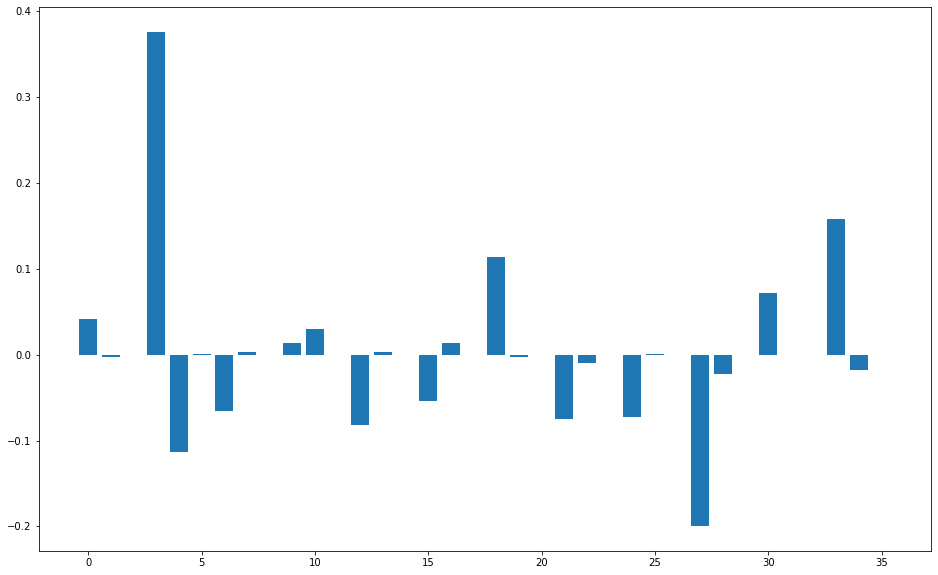

In [22]:
plt.figure(figsize=(16,10))
plt.bar(x=[i for i in range(len(x_hat))], height=x_hat)
plt.show()

In [23]:
result = A_test @ x_hat
for i in range(len(result)):
    print(result[i], '\t', b_test[i])

-0.9110481282026832 	 -0.04327603365074203
-0.13306175293512368 	 0.006837625664703428
-0.3005557264558121 	 -0.07947888545798679
-13.261553794358296 	 -0.9407839971011329
0.11717422267640443 	 -0.18256297372873373
-0.015961379511145332 	 -0.10897997891377471
-0.1273815975423481 	 -0.03514183838666374
-0.3151476841018185 	 -0.05169303430369454
0.13339888339021222 	 -0.10462397566383681
-0.10036151540030569 	 -0.382237902329892
-0.8849593253423071 	 0.3024106363546096
-0.757721267070433 	 0.0013449621789789615


In [24]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
reg = model.fit(A_train, b_train)

In [25]:
result2 = model.predict(A_test)
for i in range(len(result2)):
    print(result2[i], '\t', b_test[i])

-0.38968022083184894 	 -0.04327603365074203
0.12665981568614393 	 0.006837625664703428
-0.04409443116954026 	 -0.07947888545798679
-13.55050966091374 	 -0.9407839971011329
0.3769299829640278 	 -0.18256297372873373
0.21324222622419758 	 -0.10897997891377471
0.122572716705103 	 -0.03514183838666374
-0.08865036795610515 	 -0.05169303430369454
0.37532902883107827 	 -0.10462397566383681
0.15337539608229112 	 -0.382237902329892
-0.6127328470093073 	 0.3024106363546096
-0.5386448248151702 	 0.0013449621789789615


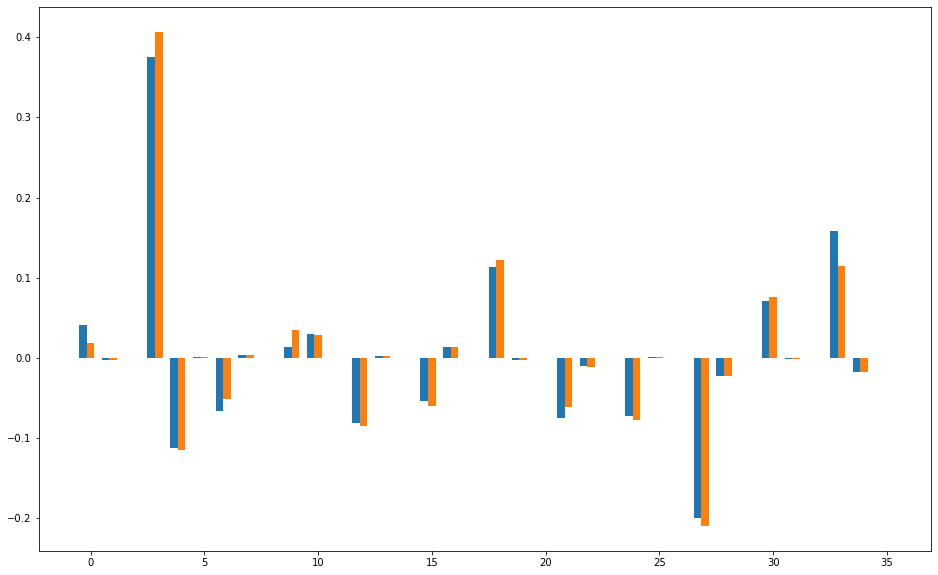

In [26]:
plt.figure(figsize=(16,10))
indices = [i for i in range(len(x_hat))]
#Calculate optimal width
width = np.min(np.diff(indices))/3

plt.bar(indices-width,x_hat,width)
plt.bar(indices,reg.coef_,width)
plt.show()